In [1]:
from model import get_spikes
from analysis.temporal import get_avg_isi, to_compare
import matplotlib.pyplot as plt

root_note = "C4"
root_spikes = get_spikes(root_note)
# root_avg_isi = get_avg_isi(root_spikes)

# print(len(root_avg_isi))

In [2]:
from model.bez2018model import get_ERB_cf_list
from analysis.temporal import create_concurrency_profile

cf_list = get_ERB_cf_list(num_cf=3500, min_cf=125, max_cf=16e3)
conc_profiles = [create_concurrency_profile(cf) for cf in root_spikes]

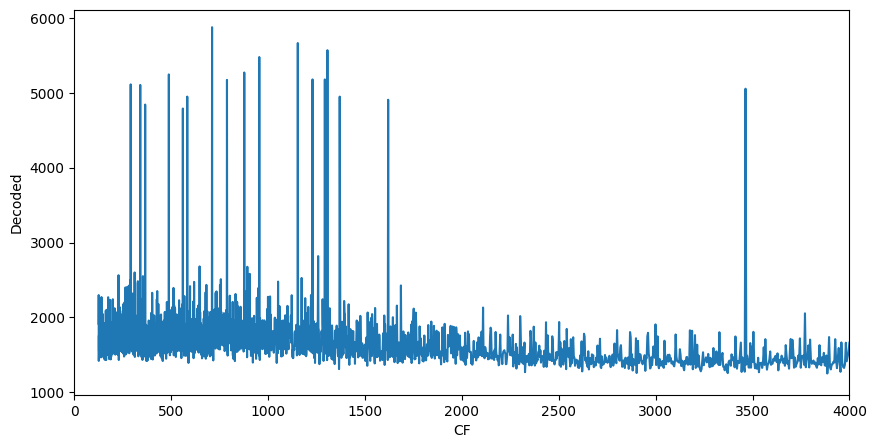

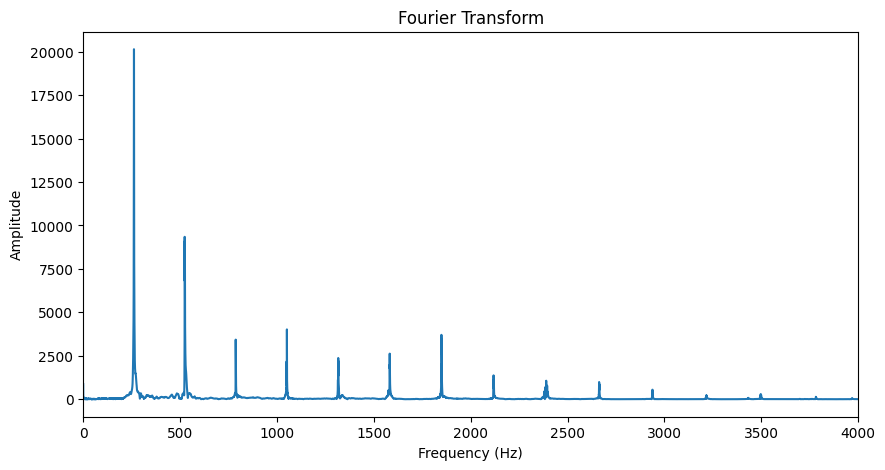

In [3]:
from analysis.spectral import plot_concurrency, fourier_note

plot_concurrency(conc_profiles, 12)

fourier_note("C4", True)

In [4]:
from model import get_spikes_abs


root_spikes_abs_20k = get_spikes_abs("C420k")
conc_profiles_abs_20k = [create_concurrency_profile(cf) for cf in root_spikes_abs_20k]

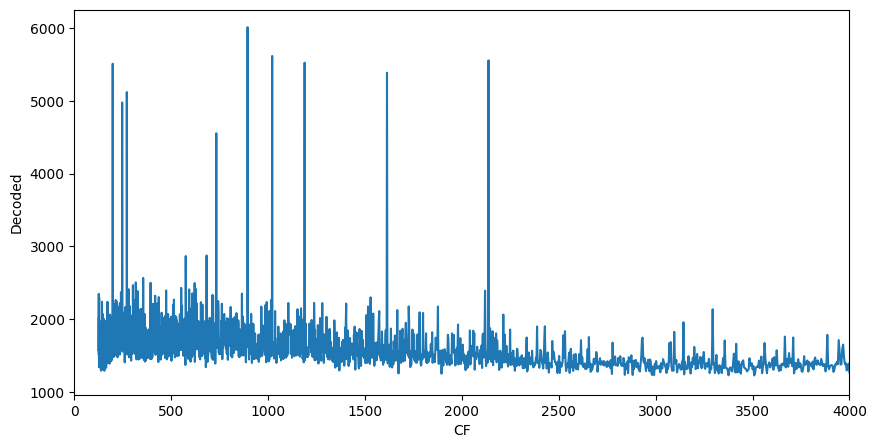

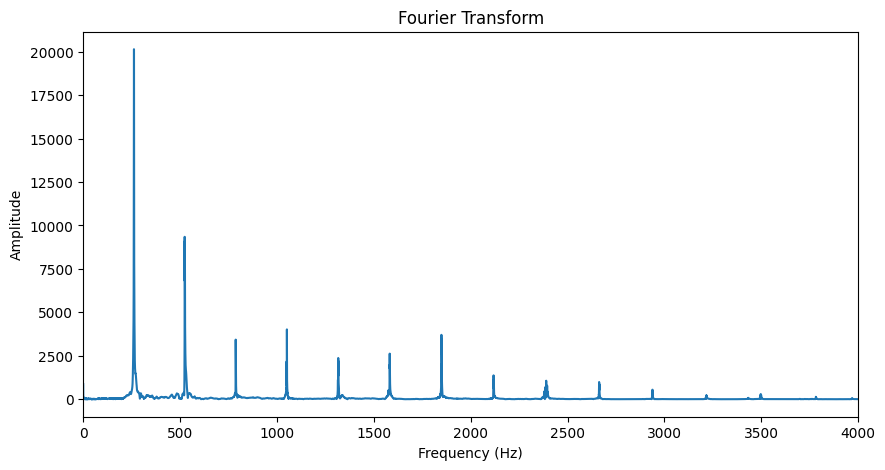

In [5]:

plot_concurrency(conc_profiles_abs_20k, 12)

fourier_note("C4", True)

In [6]:
from model import get_spikes_abs


root_spikes_abs = get_spikes_abs("C4")
conc_profiles_abs = [create_concurrency_profile(cf) for cf in root_spikes_abs]

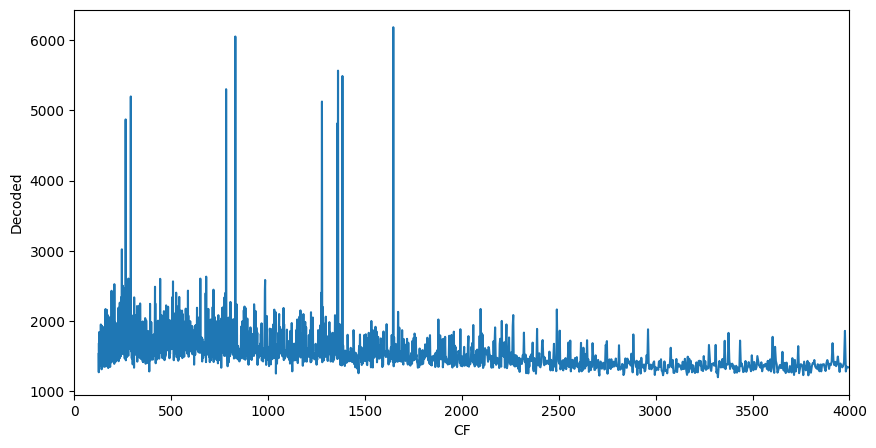

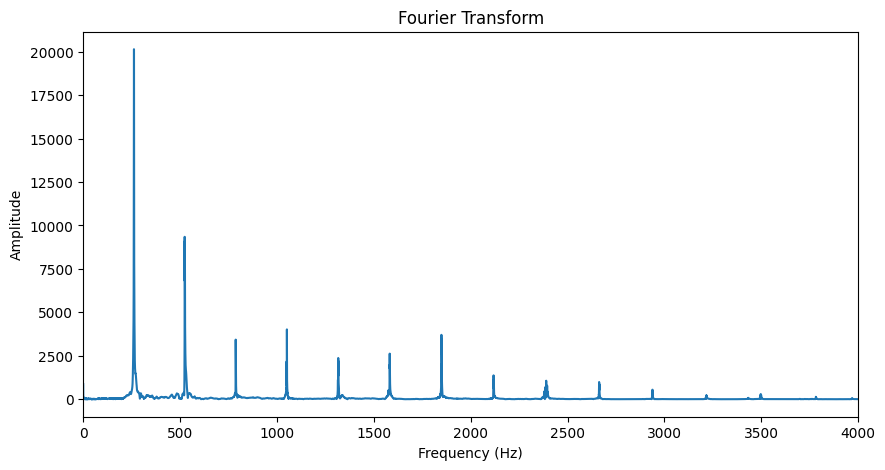

In [7]:
plot_concurrency(conc_profiles_abs, 12)

fourier_note("C4", True)

There are 3 things I can try

1. Exponential decoding + Weighting to find a center of gravity of the spikes
2. Linear decoding + Weighting to find a center of gravity of the spikes
3. Create some kind of probability model where I model neurons on a higher level connected to across the whole spectrum and the model outputs their firing rates / probability of firing

In [8]:
from math import inf
import os
from scipy.io import wavfile 
import numpy as np

NOTES_DIR = "../Iowa Notes/Mono"
def find_max():
    max_val = -inf
    for file in os.listdir(NOTES_DIR):
        if file.endswith(".wav"):
            sample_rate, data = wavfile.read(os.path.join(NOTES_DIR, file))
            # print(file, np.max(np.abs(data)))
            max_val = max(max_val, np.max(np.abs(data)))
    print(max_val)
find_max()

19346


In [9]:
from scipy.io import wavfile
import numpy as np

def fourier_analyze_significant(note):
    # Read the WAV file
    sample_rate, data = wavfile.read(f'/Users/prab/Documents/Play/Iowa Notes/Mono/{note}.wav')

    # Perform the Fourier Transform
    frequencies = np.fft.fftfreq(len(data), 1/sample_rate)
    positive_freq_idxs = np.where(frequencies > 0)
    frequencies = frequencies[positive_freq_idxs]
    fourier_transform = np.fft.fft(data)
    fourier_transform = fourier_transform[positive_freq_idxs]

    amplitudes = np.abs(fourier_transform)
    amplitudes = amplitudes / np.max(amplitudes)

    significant = []
    for i in range(len(amplitudes)):
        if amplitudes[i] > 0.05:
            significant.append((frequencies[i], amplitudes[i]))
    # Sort by amplitudes DESC
    significant.sort(key=lambda x: x[1], reverse=True)
    # significant = significant[:12]
    # Sort by frequencies ASC
    # significant.sort(key=lambda x: x[0])
    return [freq for freq, amp in significant]

def fourier_analyze_insignificant(note):
    # Read the WAV file
    sample_rate, data = wavfile.read(f'/Users/prab/Documents/Play/Iowa Notes/Mono/{note}.wav')

    # Perform the Fourier Transform
    frequencies = np.fft.fftfreq(len(data), 1/sample_rate)
    positive_freq_idxs = np.where(frequencies > 0)
    frequencies = frequencies[positive_freq_idxs]
    fourier_transform = np.fft.fft(data)
    fourier_transform = fourier_transform[positive_freq_idxs]

    amplitudes = np.abs(fourier_transform)
    amplitudes = amplitudes / np.max(amplitudes)

    insignificant = []
    for i in range(len(amplitudes)):
        if amplitudes[i] < 0.01 and frequencies[i] > 125 and frequencies[i] < 16e3:
            insignificant.append((frequencies[i], amplitudes[i]))
    # Sort by amplitudes DESC
    insignificant.sort(key=lambda x: x[1])
    # significant = significant[:12]
    # Sort by frequencies ASC
    # significant.sort(key=lambda x: x[0])
    return [freq for freq, amp in insignificant]
msg = fourier_analyze_significant(root_note)[0]
lsg = fourier_analyze_insignificant(root_note)[0]
print(msg, lsg)

262.22222222222223 13561.11111111111


13560.241425314405
262.36021981713327
[99.48186528497409, 0.5181347150259068, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[96.15952732644017, 3.5450516986706058, 0.29542097488921715, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


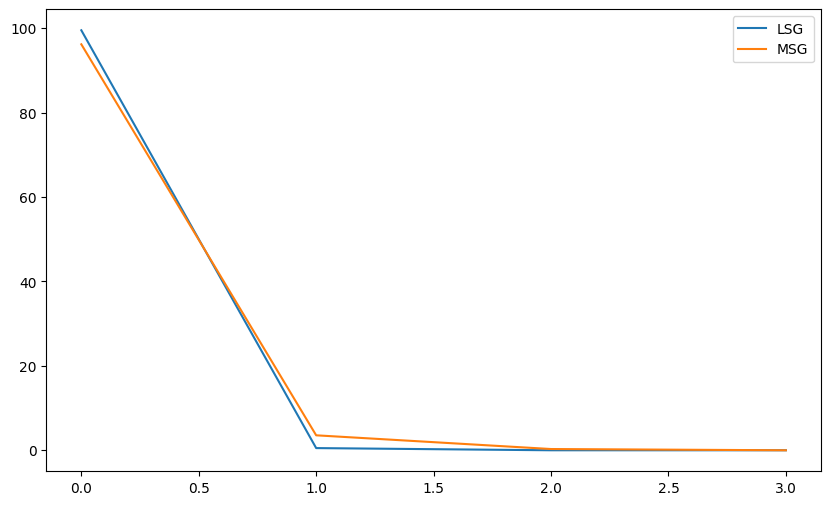

In [10]:
def find_closest_index(nums, target):
    closest_index = None
    min_diff = float('inf')
    
    for index, num in enumerate(nums):
        diff = abs(num - target)
        if diff < min_diff:
            min_diff = diff
            closest_index = index
            
    return closest_index

lsg_idx = find_closest_index(cf_list, lsg)
msg_idx = find_closest_index(cf_list, msg)

print(cf_list[lsg_idx])
print(cf_list[msg_idx])

lsg_profile = conc_profiles[lsg_idx]
msg_profile = conc_profiles[msg_idx]

print(lsg_profile)
print(msg_profile)

#plot the profiles
plt.figure(figsize=(10, 6))
plt.plot(lsg_profile[:4], label='LSG')
plt.plot(msg_profile[:4], label='MSG')
plt.legend()
plt.show()

In [11]:
import numpy
import sys
numpy.set_printoptions(threshold=sys.maxsize)

lsg_idx = 3350
msg_idx = 300

spikes = get_spikes("C4")

lsg = [np.trim_zeros(spk) for spk in spikes[lsg_idx]]
msg = [np.trim_zeros(spk) for spk in spikes[msg_idx]]



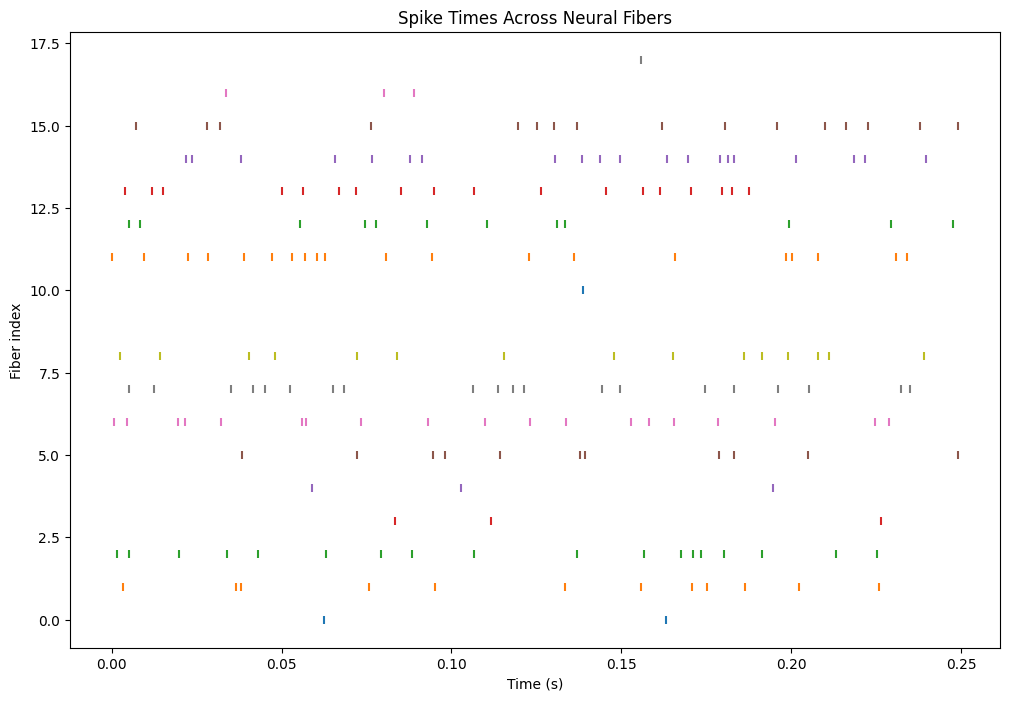

Mean Spike Time: 0.115 s
Standard Deviation of Spike Times: 0.054 s
Mean Number of Spikes: 10.8
Mean Spike Rate: 43.1 spikes/s
Observation Time: 0.25 s


(0.11462332680821419,
 0.05375455226749182,
 10.777777777777779,
 43.111111111111114)

In [12]:
from analysis.neural_fibers import analyze_neural_fibers


analyze_neural_fibers(lsg)

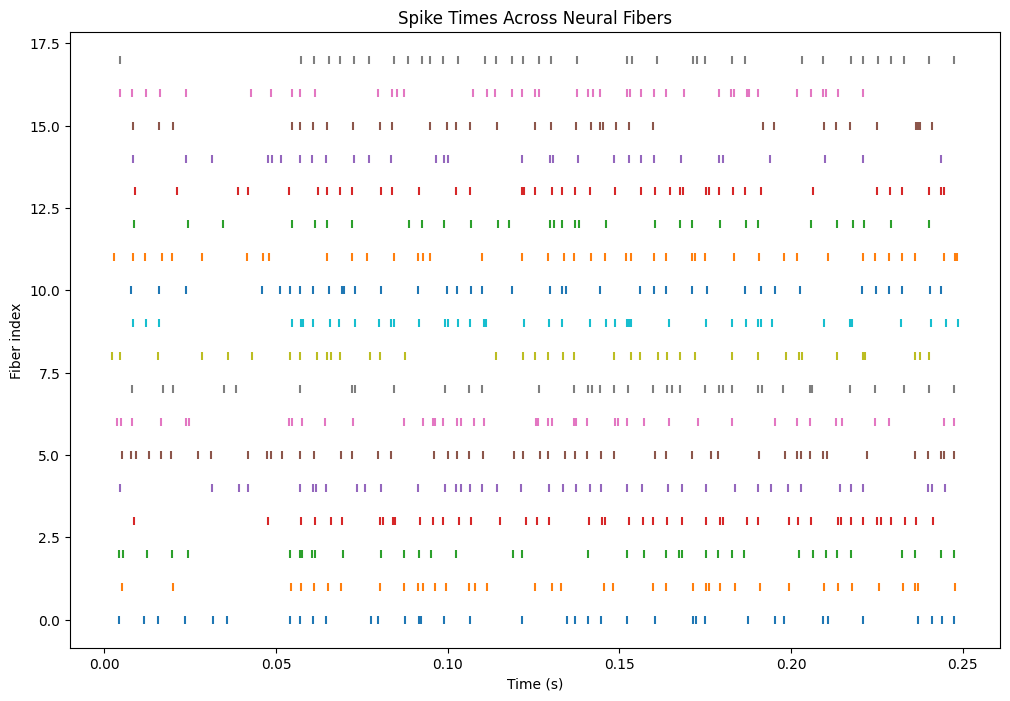

Mean Spike Time: 0.132 s
Standard Deviation of Spike Times: 0.067 s
Mean Number of Spikes: 39.2
Mean Spike Rate: 156.7 spikes/s
Observation Time: 0.25 s


(0.13158788, 0.06681839, 39.166666666666664, 156.66666666666666)

In [13]:
analyze_neural_fibers(msg)